In [198]:
import psycopg2
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from ckonlpy.tag import Twitter
from pykospacing import Spacing

In [210]:
#postgresql 접속
conn_string = "host='localhost' dbname='postgres' user='postgres' password='admin'"
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

#데이터 가져오기
cur.execute("select distinct title, date, url, hashtag from yt_clothes where title like '%슬리브%'")
conn.commit()
yy = cur.fetchall()

#DF화
yyy = pd.DataFrame(yy)
yyy.columns = ['title', 'date', 'url', 'hashtag']

#db 연결 종료
conn.cursor().close()
conn.close()

In [211]:
yyy.head()

,title,date,url,hashtag
0,팔라스 P-3D 롱슬리브 쭉티 긴팔티 블랙 L사이즈 디테일 착샷 실측 4K (Used),2022-01-31,https://www.youtube.com/watch?v=nn3l-SWdvCo,
1,[캐럿 브이로그] Ep#01 /포토카드 슬리브 구매 리뷰 / 포카정리 / 보드피아 ...,2021-07-30,https://www.youtube.com/watch?v=IMH86fkW7NQ,#캐럿로그 #포카정리
2,"2021 만오천원 이하 무지 롱슬리브 티셔츠비교 추천 [트리플에이, 프린트스타, ...",2021-09-08,https://www.youtube.com/watch?v=ReVO1CVm2Qw,#무지티 #롱슬리브 #티셔츠
3,"잼머 벌룬 숏 슬리브 티 | jammer, linen | 잼머의집 린넨 국내생산 ...",2022-05-18,https://www.youtube.com/watch?v=QC8yPZZEPkI,#잼머 #잼머의집 #린넨원피스 #린넨팬츠 #일본린넨 #프랑스린넨 #유럽린넨 #린넨샵...
4,"8브랜드 롱슬리브, 가을 기본템 뭐 사야해?",2021-09-07,https://www.youtube.com/watch?v=HbYG67K6rrA,#긴팔티 #롱슬리브 #남자패션


In [212]:
yyy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    89 non-null     object
 1   date     89 non-null     object
 2   url      89 non-null     object
 3   hashtag  89 non-null     object
dtypes: object(4)
memory usage: 2.9+ KB


In [213]:
# 모든 타이틀 제목을 연결해서 하나의 텍스트 문서로 만들려 함
titles = yyy['title'].tolist()
titles[:5]

['팔라스 P-3D 롱슬리브 쭉티 긴팔티 블랙 L사이즈 디테일 착샷 실측 4K (Used)',
 '[캐럿 브이로그] Ep#01 /포토카드 슬리브 구매 리뷰 / 포카정리 / 보드피아 / 세븐틴',
 '2021 만오천원 이하  무지 롱슬리브 티셔츠비교 추천 [트리플에이, 프린트스타, 미나브, 무탠다드] 남자 가을 코디',
 '잼머 벌룬 숏 슬리브 티  | jammer, linen | 잼머의집 린넨 국내생산 디자인등록',
 '8브랜드 롱슬리브, 가을 기본템 뭐 사야해?']

In [214]:
twitter = Twitter()
spacing = Spacing()

def rmEmoji(inputData):

    emoji_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
            "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', inputData) # no emoji

#불용어 읽어오기
stopwords = pd.read_csv("stopwords.txt")
stopwords = stopwords['word'].tolist()
stopwords.extend([',', '.', '+', '[', ']', '!', '?', '(', ')', '|', '_', '~', '#', '/'])

#외래어 읽어오기
loanwords = pd.read_csv('loanwords.txt', encoding = 'cp949')
loanwords = loanwords['word'].tolist()
for word in loanwords :
    twitter.add_dictionary(word, 'Noun')

#불용어제거 + 토큰화
tks = []
for sentence in tqdm(titles) :
    reEmoji_sent = rmEmoji(sentence) # 이모티콘 제거
    kospacing_sent = spacing(reEmoji_sent) # 띄워쓰기 보완
    tokenized_sent = twitter.morphs(kospacing_sent) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sent if not word in stopwords] # 불용어 제거
    tks.append(stopwords_removed_sentence)

c:\Users\User\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
100%|██████████| 89/89 [00:04<00:00, 19.33it/s]


In [228]:
clean_sentences = []
for tk in tks :
    clean_sentences.append(" ".join(tk))

replace_sentences = []
for sent in clean_sentences :
    replace_sentences.append(sent.replace('슬리브', ''))
replace_sentences

['팔라스 P - 3 D 롱  쭉티 긴 티 블랙 L 사이즈 디테일 착샷 실 측 4 K Used',
 '캐럿 브이로그 Ep 01 포토 카드  구매 리뷰 포카 정리 보드 피아 세븐 틴',
 '2021 만 오천 원 이하 무지 롱  티셔츠 비교 추천 트리플 에이 프린트 스타 미나 브 무탠 다드 남자 가을 코디',
 '잼머 벌룬 숏  티 jammer linen 잼머 집 린넨 국내 생산 디자인 등록',
 '8 브랜드 롱  가을 기본 템 뭐 사야 해',
 '신상 스톤 아일랜드 롱  리뷰 21 FW 신상 질러서 살펴봤습니다 후 후 :)',
 '셔츠 칼라 원피스 패턴 그리기 1 편 뒤판 패턴 남방 칼라 돌 먼  벨트 형 원피스',
 '빈티 지 주름  그레이 블루 블라우스',
 '무조건 봐야 하는 미친 갓 성비 무지 기본 템 추천 코디 방법 긴  맨투맨 니트',
 '시 즈 니 브이로그 글리치 모드 아직 못 보내 팝업 2 차 MD 준 등기 깡 택배 깡 콜렉트 북 바인더 대지 바인더 정리 팝 콘 게임 즈  포스터 발주',
 '시 즈 니 브이  50 장 사려 다가 500 장 잘못 샀음 ㅋㅋ • 엔시 티 포카 정리 • 포카 바인더 정리 •  갈아 끼기 • 팝 콘 게임 즈 카드  • 젠프',
 'COS 리뷰 봄 신상 니트 티 푸 크시 핑크 ㅣ 쇼트  ㅣ 69,000 KRW ㅣ L',
 '시 즈 니 브이로그 • 준 기 깡 • 천프 •  꾸 미기 • 슬꾸 • 러디 말 했 어요 • 스티커 • 6 공 바인더 • 꾸 미기 • 미 공포 사기 당했 어요 • 드프',
 '봄 여성 피트니스 복 베이직 숏  스리 브 티',
 '어깨 라인 쁜 돌 먼  스타일 반팔 티 만들기 ~!( 패턴 편',
 '비스 스트링 롱 ',
 '밀 링스 핀 밀링 헤드 티  - 이레 정공',
 ' 리스 민소매 끈 나시 셔링 프릴 롱 원피스 #sh orts',
 '반 접착 자켓  헤드 막구 라지 달기 1',
 '... 진짜 갓 성비 긴 티 찾았습니다 \u200d♂️ 남자 롱  ㄴㅐ 돈 내 산',
 '남자 롱  브랜드 추천 5 종 비

In [229]:
# title수 * title수 의 TF-IDF 상관행렬 만들기
n = len(replace_sentences)
text_mat = np.zeros(shape=(n,n), dtype=np.float64)

#TF-IDF
tfidf = TfidfVectorizer(analyzer='word', encoding='utf-8')
tfidf.fit(replace_sentences)

TfidfVectorizer()

In [230]:
tfidf.vocabulary_

{'팔라스': 444,
 '쭉티': 407,
 '블랙': 249,
 '사이즈': 264,
 '디테일': 162,
 '착샷': 409,
 'used': 82,
 '캐럿': 422,
 '브이로그': 247,
 'ep': 38,
 '01': 2,
 '포토': 459,
 '카드': 419,
 '구매': 109,
 '리뷰': 181,
 '포카': 457,
 '정리': 386,
 '보드': 236,
 '피아': 469,
 '세븐': 275,
 '2021': 6,
 '오천': 344,
 '이하': 367,
 '무지': 210,
 '티셔츠': 443,
 '비교': 252,
 '추천': 416,
 '트리플': 441,
 '에이': 333,
 '프린트': 464,
 '스타': 294,
 '미나': 213,
 '무탠': 211,
 '다드': 138,
 '남자': 129,
 '가을': 94,
 '코디': 425,
 '잼머': 382,
 '벌룬': 228,
 'jammer': 53,
 'linen': 56,
 '린넨': 186,
 '국내': 110,
 '생산': 271,
 '디자인': 160,
 '등록': 159,
 '브랜드': 245,
 '기본': 119,
 '사야': 263,
 '신상': 309,
 '스톤': 298,
 '아일랜드': 318,
 '21': 8,
 'fw': 43,
 '질러서': 406,
 '살펴봤습니다': 267,
 '셔츠': 278,
 '칼라': 421,
 '원피스': 357,
 '패턴': 449,
 '그리기': 114,
 '뒤판': 153,
 '남방': 128,
 '벨트': 233,
 '빈티': 255,
 '주름': 394,
 '그레이': 112,
 '블루': 251,
 '블라우스': 248,
 '무조건': 209,
 '봐야': 242,
 '하는': 479,
 '미친': 216,
 '성비': 274,
 '방법': 225,
 '맨투맨': 201,
 '니트': 135,
 '글리치': 115,
 '모드': 205,
 '아직': 319,
 '보내': 235,
 '팝업

In [231]:
#문장의 모든 순서쌍마다 vector 간의 cosine similarity를 구함
from sklearn.metrics.pairwise import cosine_similarity

for idxi, i in enumerate(clean_sentences) :
    for idxj, j in enumerate(clean_sentences) :
        # row, col이 같으면 스킵
        if idxi == idxj:
            continue
        
        text_mat[idxi][idxj] = cosine_similarity(tfidf.transform([i]), tfidf.transform([j]))[0][0]

text_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [232]:
# 인접리스트 방식으로 노드 간의 연결관계 표현

mat = text_mat.copy()
output_node = []

for row in mat:
    tmp=[]
    for i in range(len(row) ):
        if row[i]>0 :
            tmp.append(i)
    output_node.append(tmp)


for i in range(len(output_node)) :
    print(len(output_node[i]), end=' ')

7 29 28 2 12 10 16 2 29 17 18 16 14 1 13 0 2 15 2 5 25 3 3 0 21 9 22 22 1 0 17 7 22 21 11 27 5 29 6 7 14 18 3 15 26 16 9 3 22 11 3 10 10 11 0 11 21 23 11 24 20 33 24 16 1 20 8 13 7 5 0 0 5 29 9 3 23 9 13 17 7 20 23 25 13 29 2 4 3 

In [233]:
d = 0.85
initial_tr=1/len(mat)
TR = [initial_tr]*len(mat)

TR

[0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.011235955056179775,
 0.01123595

In [234]:
#while문을 탈출하기 위한 boolean 변수
stop = False

#error 값을 저장하기 위한 변수
history = []
step = 0

while stop == False:
    # A,B,C,D를 업데이트할 때 원래값과 수정된 값의 차이의 합
    #error = S_k+1(V_i) + S_k(V_i)
    total_error = 0
    # A,B,C,D를 순회하면서
    for node in range(len(mat)):
        # 초항 : 1-d
        update_val = (1-d)
        tmp = 0
        # A 노드와 연결된 노드 중에서 (B, D)
        for i in output_node[node] :
            s=0
            # B에 연결된 노드의 가중치 합을 S에 저장
            for j in output_node[i] :
                s+= mat[i][j]
            # TR['B'] * mat[A->B] / sigma(B)
            k=TR[i]*(mat[node][i]/s)
            tmp += k
        # update_val은 기존의 1-d + d*tmp, d=0.85
        update_val +=tmp*d
        # error는 기존값과 update_val의 차이
        error = abs(TR[node] - update_val)
        # total_error에 error를 더해줌
        total_error += error
        TR[node] = update_val
        #만약 error가 e^-10보다 작다면 early stop flag
    if total_error < 1e-10:
        stop = True
    
    history.append(total_error)
    step+=1
    print("step:", step, " error:", total_error)
    if stop == True :
        break

step: 1  error: 19.787679446173268
step: 2  error: 16.84317489465331
step: 3  error: 12.607465138329056
step: 4  error: 9.196664110930312
step: 5  error: 6.682058932405944
step: 6  error: 4.855441626975867
step: 7  error: 3.5289941525682034
step: 8  error: 2.565304491417993
step: 9  error: 1.864950115953944
step: 10  error: 1.3558804507481352
step: 11  error: 0.985808927987684
step: 12  error: 0.7167634113697101
step: 13  error: 0.5211552854172421
step: 14  error: 0.37893471411867036
step: 15  error: 0.2755281646737388
step: 16  error: 0.20034148149586029
step: 17  error: 0.14567273416094018
step: 18  error: 0.1059223536173527
step: 19  error: 0.0770191168414811
step: 20  error: 0.056002925613158394
step: 21  error: 0.04072151700431398
step: 22  error: 0.029609977143727817
step: 23  error: 0.021530442954943108
step: 24  error: 0.015655557392258268
step: 25  error: 0.01138373327697545
step: 26  error: 0.008277542938869786
step: 27  error: 0.006018921588088699
step: 28  error: 0.00437659

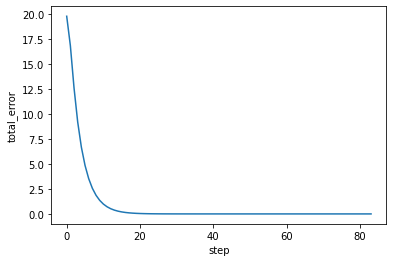

In [235]:
import matplotlib.pyplot as plt
plt.figure.figsize=(10, 10)
plt.ylabel('total_error')
plt.xlabel('step')
plt.plot(history)

In [236]:
# 업데이트된 TR
print(TR)

[0.4240269042394195, 1.8370302815361912, 1.3870902790105721, 0.6619247535892788, 1.3122033202138703, 0.5661030852490547, 1.5766507637568643, 0.2844252422483241, 1.8122783905182787, 0.9973576170218001, 1.420004663600694, 0.8666873770237207, 0.6244442853023542, 0.9999999999983854, 1.4818171550684158, 0.15000000000000002, 0.45274973356845705, 1.1864988615597065, 0.444181917245762, 0.49103200576428957, 1.9028294822545981, 0.4103683424224359, 0.3756487674649953, 0.15000000000000002, 0.9986542545215898, 0.7280548496362227, 0.9989805741243404, 1.1670780580237383, 0.25865252164998276, 0.15000000000000002, 1.3160456788389334, 0.6215271884440352, 1.1763303466794648, 1.1445483237813456, 1.0457188434054947, 1.5453096467458987, 0.426892773610256, 1.539889336816199, 1.2435823769953167, 0.510826094490386, 0.7043196242270874, 1.8302607339874748, 0.636730930981978, 0.8499688290765223, 1.1253537510471783, 1.576650763757462, 1.3194200281706543, 0.629087176470497, 1.1107452002856815, 1.0090179750250519, 0

In [240]:
#정렬
ans=[]
for idx, val in enumerate(TR) :
    ans.append((val, idx))

# 내림차순 정렬 & 상위 5개 선택
bot_5 = sorted(ans, reverse=True)[:5]

bot_5

[(2.1057808769868887, 61),
 (1.9704961099368203, 65),
 (1.9028294822545981, 20),
 (1.8370302815361912, 1),
 (1.834426613612016, 73)]

In [241]:
for idx, i in enumerate(bot_5) :
    print(idx+1, '번째: ', clean_sentences[i[1]], i[0])

1 번째:  기본 템 총 정 리 봄 코디 필수 티셔츠 슬리브 리스 셔츠 싹 가져옴 찐 추천 인생 템 ‍♀️ 2.1057808769868887
2 번째:  시 즈 니 브이로그 엔시 티 포카 정리 팝콘 게임 즈 카드 슬리브 콜렉트 북 정리 3 공 바인더 nct 포토 카드 늦덕 학생 즈 니 브이로그 1.9704961099368203
3 번째:  남자 롱 슬리브 브랜드 추천 5 종 비교 리뷰 ‍♂️ 단 품 1.9028294822545981
4 번째:  캐럿 브이로그 Ep 01 포토 카드 슬리브 구매 리뷰 포카 정리 보드 피아 세븐 틴 1.8370302815361912
5 번째:  캐럿 브이로그 보드 피아 카드 슬리브 리뷰 • 바인더 정리 • 포카 정리 Boa rdpia Card Sleeves review • Binder 시 아호 로그 1.834426613612016
